# Build a Image Classifier From Scratch
> In this tutorial, we will train an image classifier from scratch instead of using transfer learning. Through the process, we will show a few techniques that can help achieve better performance. 

First, we need some data to work with. For this tutorial, we will use the Imagenette dataset from fastai. This is a subset of the Imangenet dataset. It selects 10 very different classess from the full Imagenet dataset. 

In [ ]:
from fastai.vision.all import *
data_path = untar_data(URLs.IMAGENETTE)

/Users/jerryyu/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/jerryyu/opt/anaconda3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/jerryyu/opt/anaconda3/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <9E417059-FF86-3C93-B8D5-8A071C12B008> /Users/jerryyu/opt/anaconda3/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <3BC89DD9-AAC2-3081-A655-ECB993924628> /Users/jerryyu/opt/anaconda3/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python ext

Let's take a look at the structure of this dataset so that we can build our datablock
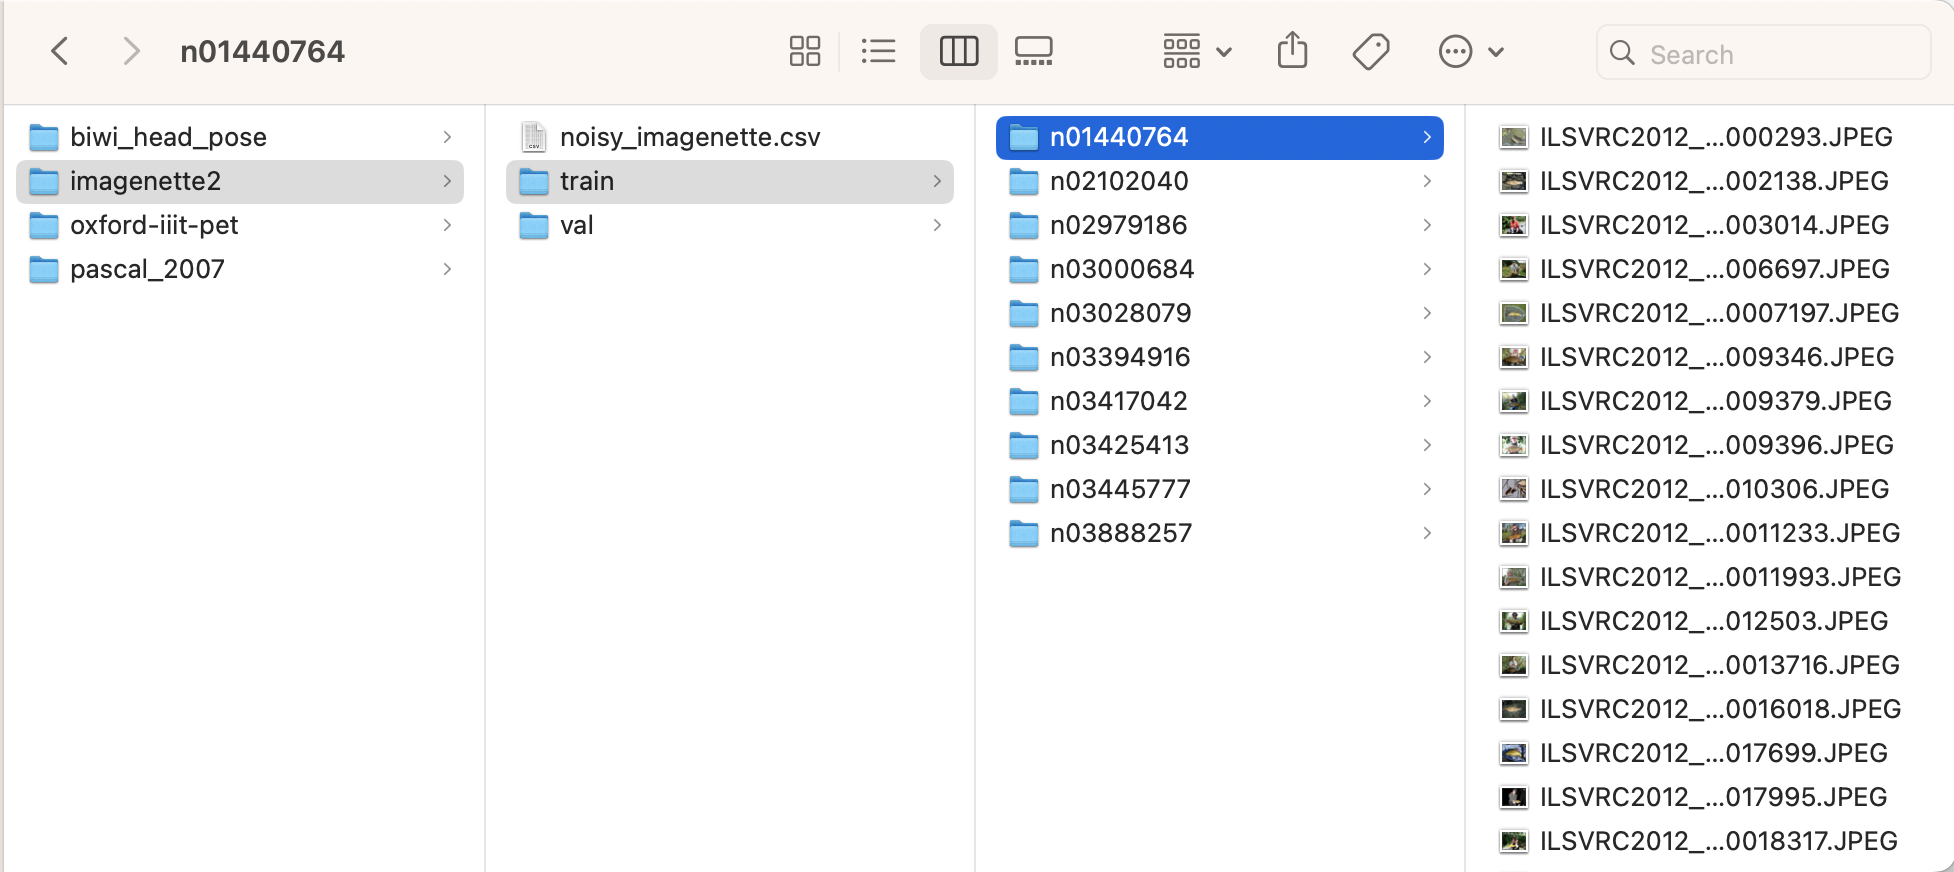

Training and validation data is separated in its own folder. Inside train and val, there are 10 classes each has its own folder. The folder name is the class label. Images of each class are stored in its coressponding class folder. 

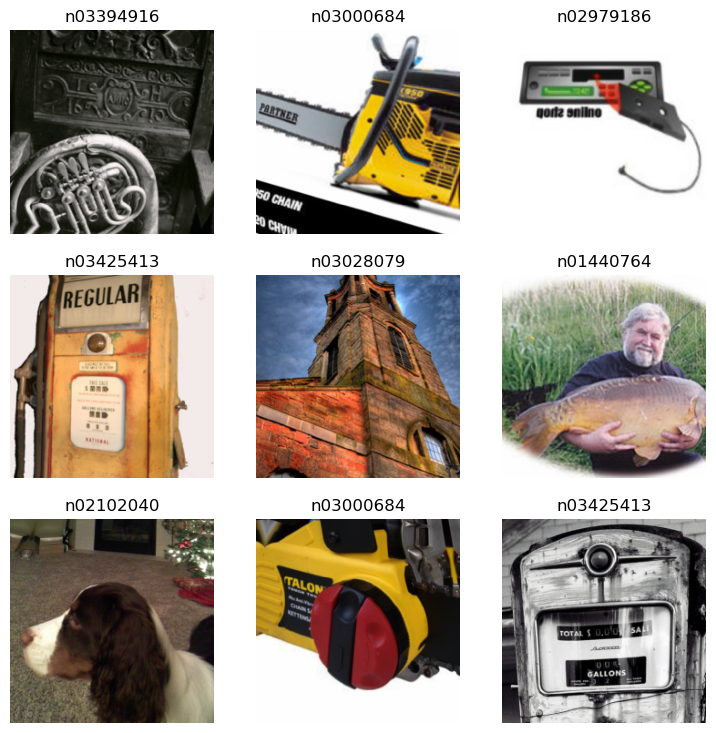

In [ ]:
dblocks = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items = get_image_files, 
    get_y = parent_label, 
    item_tfms = Resize(460), 
    batch_tfms = aug_transforms(size=224, min_scale=0.75))

dls = dblocks.dataloaders(data_path, bs=64)
dls.show_batch()

The labels are not very readable. Let's change them to something easier to understand. Let's create a function to map the original label to a human readable label and use this function in our DataBlock. We also want to specify a splitter to use images in the train folder for traning data and images in the val folder for validation data. 

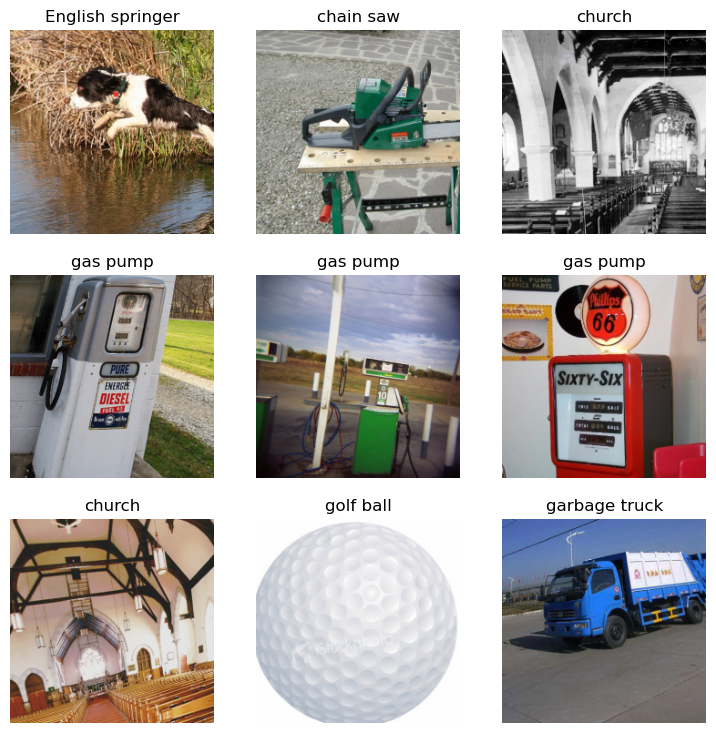

In [ ]:
label_lookup = dict(
    n01440764='tench',
    n02102040='English springer',
    n02979186='cassette player',
    n03000684='chain saw',
    n03028079='church',
    n03394916='French horn',
    n03417042='garbage truck',
    n03425413='gas pump',
    n03445777='golf ball',
    n03888257='parachute'
)

def get_label(image_path):
    label = parent_label(image_path)
    return label_lookup[label]
    
dblocks = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items = get_image_files, 
    get_y = get_label, 
    splitter = GrandparentSplitter(train_name='train', valid_name='val'),
    item_tfms = Resize(460), 
    batch_tfms = aug_transforms(size=224, min_scale=0.75))

dls = dblocks.dataloaders(data_path, bs=64)
dls.show_batch()

Now our data is ready. Let's create a model from scratch and get a baseline of our model performance

In [ ]:
model = xresnet50(pretrained=False)
learner = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learner.fit_one_cycle(5, lr_max=0.003)

epoch,train_loss,valid_loss,accuracy,time
0,1.737712,2.343394,0.381911,1:12:19
1,1.290873,1.469322,0.569427,1:17:06
2,1.033922,1.083741,0.661656,1:12:29
3,0.779879,0.699522,0.780127,1:06:40
4,0.634020,0.603678,0.814268,1:08:30


This is a good baseline for our model performance. Let's find ways to improve our model. First we will look at normalization. 

## Normailizaiton

Normalization means bringing values to a similar scale. Normalization improve the performance and training stability of the model. We will normalize our data to the same mean and standard deviation of the Imagenet dataset since our data is a subsut of the Imagenet dataset. 

In [ ]:
dblocks = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items = get_image_files, 
    get_y = get_label, 
    splitter = GrandparentSplitter(train_name='train', valid_name='val'),
    item_tfms = Resize(460), 
    batch_tfms = [*aug_transforms(size=224, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])

dls = dblocks.dataloaders(data_path, bs=64)
x,y = dls.one_batch()
x.mean(dim=[0,2,3]), x.std(dim=[0,2,3])

(TensorImage([-0.0023,  0.0931,  0.2008]),
 TensorImage([1.2750, 1.2831, 1.3656]))

In [ ]:
model = xresnet50(n_out=dls.c, pretrained=False)
learner = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learner.fit_one_cycle(5, lr_max=0.003)

## Progressive Resizing

To get better result, we can also use pregressive resizing. What that mean is we start training with smaller images so that we can train faster. We gradually increase the size of the images so that we can include more detail in our training data. 

In [ ]:
def get_dls(size, bs):
    dblocks = DataBlock(
        blocks=(ImageBlock, CategoryBlock), 
        get_items = get_image_files, 
        get_y = get_label, 
        splitter = GrandparentSplitter(train_name='train', valid_name='val'),
        item_tfms = Resize(460), 
        batch_tfms = [*aug_transforms(size=size, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
    return dblocks.dataloaders(data_path, bs=bs)

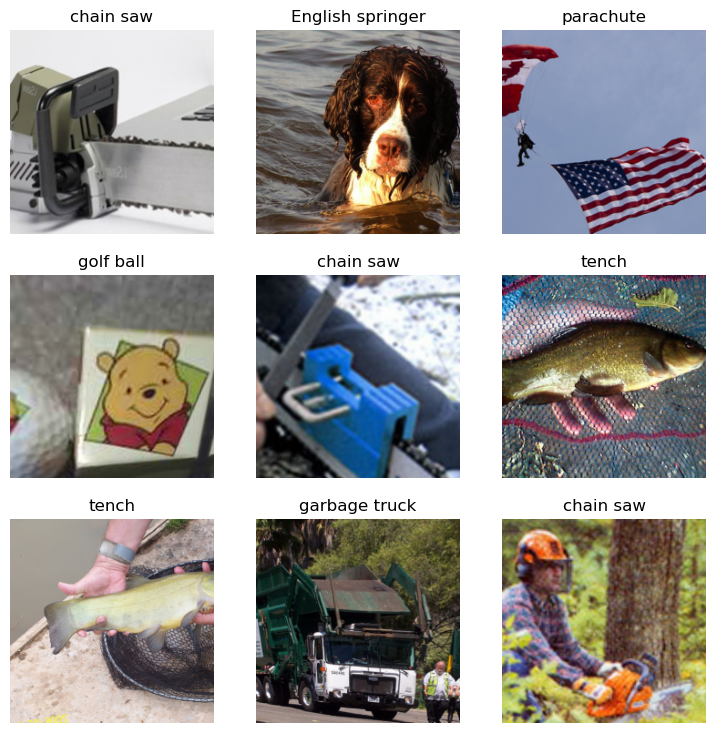

In [ ]:
dls = get_dls(128, 64)
model = xresnet50(n_out=dls.c, pretrained=False)
learner = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learner.fit_one_cycle(4, lr_max=0.003)

Next we increase the size of the images and use fine_tune to make our model adopt the new images. We use fine_tune because this is like transfer learning where we take a pretrained model and fine tune it for new data. 

In [ ]:
dls = get_dls(224, 64)
learner = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learner.fine_tune(5, max_lr=0.001)

## Test Time Augmentation

So far we have only applied augmentation to our training dataset. We can do the some thing to our validation set as well. By doing that we will get a prediction for each augmented imange and we can average them to get our final prediction. 

In [ ]:
preds, targets = learner.tta()
accuracy(preds, targets)

## Mixup

Mixup is an augmentation technique where we create a new input by mixing two images by a random weight. In pseudocode, it works like this:

image1,target1 = dataset[randint(0,len(dataset)] <br>
image2,target2 = dataset[randint(0,len(dataset)]<br>
lam = random_float(0.5, 1) //This is the ramdom weight <br>
new_input = lam * image1 + (1-lam) * image2<br>
new_target = lam * target1 + (1-lam) * target2<br>

Note from the pseudocode above, targets are one-hot encoded. The new target is a weighted sum of the targets of the two images. The loss function will then change to 

new_loss = loss_func(preds, new_target)

In practice, tartgets are integers and not one-hot encoded. If targets are not one-hot encoded, the above loss funcction can be rewritten as:

new_loss = lam * loss_func(preds, y1) + (1-lam) * loss_func(preds, y2). 

where y1 and y2 are the integer labels of image1 and image2 respetively. 

In fastai, we don't need to worry about all these implementation detail. All we need to do is to pass mixup to the cbs parameter when creating the learner. 

In [ ]:
model = xresnet50(n_out=dls.c, pretrained=False)
learner = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy, cbs=Mixup())
learner.fit_one_cycle(5, lr_max=0.003)

It requires more more epocs to see the improvements from mixup.

## Label Smoothing

Our model has the tendency to go extreme. Even an outpout of 0.999 is not good enough. There is still a gradient and our model will still try to get even closer to 1. However, 1 is a value we can never get in a Sigmoid or Softmax function. Therefor the more epocs we train, the more extreme our model becomes. To solve that, we can use label smoothing. 

In theoretical expression, labels of classification models are one-hot encoded. In practice, labels are not one-hot encoded to save memory but the loss is the same loss. In the settings of one-hot encoded labels, label smoothing changes 1 to a value slightly than 1 and changes 0 to a value slightly greater than 0. 

1. Change all 0 to 0 + epsilon / N where N is the number of classes and epsilon is a parameter we can set (usually 0.1 which means we are 10% unsure of our labels)
2. Change 1 to 1 - epsilon * (N-1) / N

By doing this all the labels still add up to 1. To use label smoothing in Fastai, we only need to change the loss function.

In [ ]:
model = xresnet50(n_out=dls.c, pretrained=False)
learner = Learner(dls, model, loss_func=LabelSmoothingCrossEntropy(), metrics=accuracy)
learner.fit_one_cycle(5, lr_max=0.003)

Label smoothing does not work well with mixup because label smoothing has modified the labels by some factor.

## Finding the Best Learning Rate

Having a good learning rate is important for our training. If the learning rate is too low, it will take a long time to train our model and we may overfit our training data. If the learning rate is too high, our loss may get bigger and bigger instead of descresing. To find the best learning rate, we can use the lr_find method. 

In [ ]:
model = xresnet50(n_out=dls.c, pretrained=False)
learner = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learner.lr_find()

## Weight Decay

Another name for weight decay is regularization. It means adding sum of square of all the parameters to the loss function.

loss_with_wd = loss + wd * (parameters ** 2).sum()

Where wd is a parameter to control the amount of regularation applied to our model. The effect of adding the regularation term is to make the value of the parameters smaller hence the name weight decay. Smaller weights will lead to a smoother hypothesis function and less prone to overfit. 

To apply weight decay in fastai, simply pass a value to wd in the fit_one_cycle call.

In [ ]:
model = xresnet50(n_out=dls.c, pretrained=False)
learner = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learner.fit_one_cycle(5, lr_max=0.003, wd=0.1)